# Clustering the Beaded Helix Transtion from R- to L-Helix

## Import Libraries

In [1]:
import sys
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from shapeGMMTorch import torch_sgmm
from shapeGMMTorch import scripts
import MDAnalysis as md
import torch

/Users/mmccull/opt/anaconda3/envs/nomkl/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Read trajectory

In [2]:
prmtopFileName = "helix_template.pdb"
trajFileName = "run_files/helix_folding_eps6.0.dcd"
coord = md.Universe(prmtopFileName,trajFileName)
print("Number of atoms in trajectory:", coord.atoms.n_atoms)
print("Number of frames in trajectory:", coord.trajectory.n_frames)
# make atom selection
atomSel = coord.select_atoms('all')
print("Number of atoms in selection:", atomSel.n_atoms)
# create traj data of selection
trajData = np.empty((coord.trajectory.n_frames,atomSel.n_atoms,3),dtype=float)
#loop traj
for ts in coord.trajectory:
    trajData[ts.frame,:] = atomSel.positions

Number of atoms in trajectory: 12
Number of frames in trajectory: 100001
Number of atoms in selection: 12


## Run WSGMM for nClusters=3

In [3]:
wsgmm = scripts.sgmm_fit_with_attempts(trajData, 3, 10, np.ones(trajData.shape[0]),device=torch.device("cpu"),dtype=torch.float64)

Number of training frames: 100001
Number of clusters: 3
Number of attempts: 10
 Attempt  Log Like per Frame    CPU Time (s)
--------------------------------------------------
       1              43.060         327.871
       2              43.074         229.519
       3              43.083         216.354
       4              43.043         229.795
       5              43.072         201.603
       6              43.076         180.525
       7              43.061         318.152
       8              43.076         301.973
       9              43.067         307.895
      10              43.058         265.387


In [4]:
# check cluster populations
print(wsgmm.weights)

[0.43828295 0.43790593 0.12381112]


In [5]:
# save pickled object
import pickle
file_obj = open("sgmm_beaded_helix_100k_v02_3clusters.pickle","wb")
pickle.dump(wsgmm,file_obj)
file_obj.close()

In [3]:
# load pickled object
import pickle
file_obj = open("sgmm_beaded_helix_100k_v02_3clusters.pickle","rb")
wsgmm = pickle.load(file_obj)
file_obj.close()

## Create ENMs from Sample Covariance

In [4]:
from shapeGMMTorch import torch_align
def _pinv(sigma,n):
    e, v = np.linalg.eigh(sigma)
    e[:n] = 0.0
    e[n:] = 1/e[n:]
    return np.dot(v,np.dot(np.diag(e),v.T))

In [5]:
dtype = torch.float64
device = torch.device("cpu")
sample_covars = np.empty((wsgmm.n_clusters,wsgmm.n_atoms*3,wsgmm.n_atoms*3))
sample_precisions = np.empty((wsgmm.n_clusters,wsgmm.n_atoms*3,wsgmm.n_atoms*3))
for cluster_id in range(wsgmm.n_clusters):
    indeces = np.argwhere(wsgmm.cluster_ids==cluster_id).flatten()
    traj_tensor = torch.tensor(trajData[indeces],dtype=dtype,device=device)
    torch_align.torch_remove_center_of_geometry(traj_tensor,dtype=dtype,device=device)
    ref_tensor = torch.tensor(wsgmm.centers[cluster_id],dtype=dtype,device=device) 
    precision_tensor = torch.tensor(wsgmm.precisions[cluster_id],dtype=torch.float64,device=device)
    traj_tensor = torch_align.torch_align_kronecker(traj_tensor,ref_tensor,precision_tensor,dtype=dtype,device=device)
    disp = traj_tensor - ref_tensor
    disp = disp.reshape(-1,wsgmm.n_atoms*3)
    sample_covars[cluster_id] = (disp.T @ disp).cpu().numpy()/(disp.shape[0]-1)
    sample_precisions[cluster_id] = _pinv(sample_covars[cluster_id],6)

In [10]:
np.savetxt("cluster1_center.dat",wsgmm.centers[0])
np.savetxt("cluster1_sample_covar.dat",sample_covars[0])
np.savetxt("cluster1_sample_precision.dat",sample_precisions[0])
np.savetxt("cluster2_center.dat",wsgmm.centers[1])
np.savetxt("cluster2_sample_covar.dat",sample_covars[1])
np.savetxt("cluster2_sample_precision.dat",sample_precisions[1])

In [15]:
dtype=torch.float64
device=torch.device("cpu")
from shapeGMMTorch import torch_align
def compute_position_hessian_energy(pos_traj,wsgmm,sample_prec1,sample_prec2):
    # metadata
    n_frames = pos_traj.shape[0]
    n_atoms = pos_traj.shape[1]
    # declare array
    energy = np.empty(n_frames)
    # Pass arrays to torch
    traj_tensor = torch.tensor(pos_traj,dtype=dtype,device=device)
    ref1_tensor = torch.tensor(wsgmm.centers[0],dtype=dtype,device=device)
    ref2_tensor = torch.tensor(wsgmm.centers[1],dtype=dtype,device=device)
    prec1_tensor = torch.tensor(wsgmm.precisions[0],dtype=dtype,device=device)
    prec2_tensor = torch.tensor(wsgmm.precisions[1],dtype=dtype,device=device)
    # align trajectory to both references and compute displacement 
    align1 =  torch_align.torch_align_kronecker(traj_tensor,ref1_tensor, prec1_tensor,dtype=dtype,device=device)
    disp1 = (align1 - ref1_tensor).cpu().numpy().reshape(n_frames,n_atoms*3)
    align2 =  torch_align.torch_align_kronecker(traj_tensor,ref2_tensor, prec2_tensor,dtype=dtype,device=device)
    disp2 = (align2 - ref2_tensor).cpu().numpy().reshape(n_frames,n_atoms*3)
    # loop through trajectory and compute energy
    for i in range(n_frames):
        energy1 = 0.5*np.dot(disp1[i],np.dot(sample_prec1,disp1[i]))
        energy2 = 0.5*np.dot(disp2[i],np.dot(sample_prec2,disp2[i]))
        energy[i] = min(energy1,energy2)
    return energy

In [16]:
energies = compute_position_hessian_energy(trajData,wsgmm,sample_precisions[0],sample_precisions[1])

In [18]:
position_enm_energies = np.loadtxt("enm_energies_v02.dat")

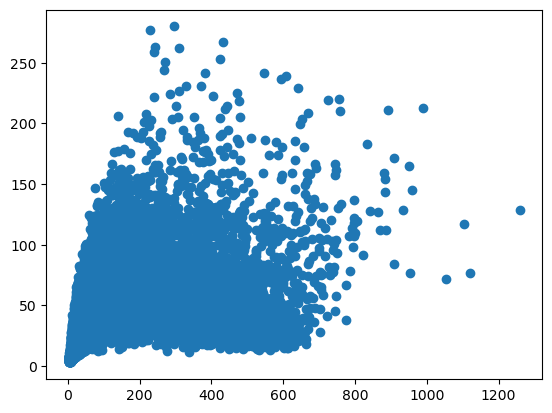

In [19]:
plt.plot(energies,position_enm_energies,'o')

In [20]:
weights = np.exp(-np.array(energies)/0.593)
weights /= np.sum(weights)
np.savetxt('hessian_weights.dat',weights)

1.282971358844796e-69 0.015106003636624593
7.744086501379749e-60 0.021499714756853756


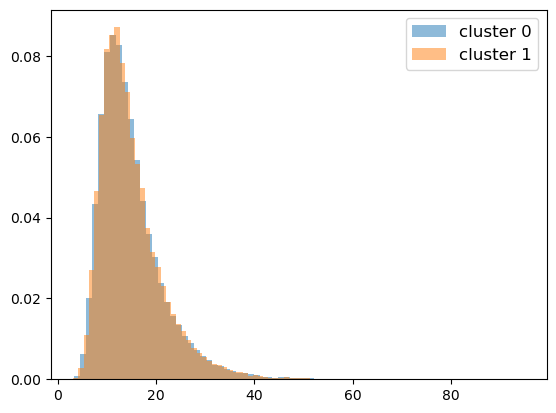

In [23]:
for cluster_id in range(wsgmm.n_clusters-1):
    indeces = np.argwhere(wsgmm.cluster_ids==cluster_id).flatten()
    print(np.amin(weights[indeces]),np.amax(weights[indeces]))
    label = "cluster " + str(cluster_id)
    plt.hist(energies[indeces],bins=75,alpha=0.5,density=True,label=label)
#plt.xlim(0,300)
plt.legend(fontsize=12);

1.282971358844796e-69 0.015106003636624593
7.744086501379749e-60 0.021499714756853756


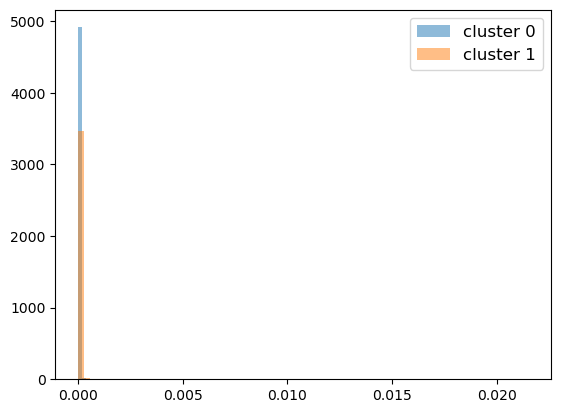

In [24]:
for cluster_id in range(wsgmm.n_clusters-1):
    indeces = np.argwhere(wsgmm.cluster_ids==cluster_id).flatten()
    print(np.amin(weights[indeces]),np.amax(weights[indeces]))
    label = "cluster " + str(cluster_id)
    plt.hist(weights[indeces],bins=75,alpha=0.5,density=True,label=label)
#plt.xlim(0,300)
plt.legend(fontsize=12);

In [8]:
ks = np.zeros((wsgmm.n_atoms-1))
k_counts = np.zeros((wsgmm.n_atoms-1))
for cluster_id in range(wsgmm.n_clusters-1):
    for atom1 in range(wsgmm.n_atoms-1):
        ki = 0
        for atom2 in range(atom1+1,wsgmm.n_atoms):
            prec_tensor = sample_precisions[cluster_id,atom1*3:atom1*3+3,atom2*3:atom2*3+3]
            sep_vec = wsgmm.centers[cluster_id,atom2]-wsgmm.centers[cluster_id,atom1]
            sep_vec /= np.linalg.norm(sep_vec)
            x = np.dot(sep_vec,np.dot(prec_tensor,sep_vec))
            ks[ki] += x
            k_counts[ki] += 1
            ki += 1
ks /= k_counts
ks = -ks
ks[ks < 0.0] = 0.0
print(0.5*ks)

[60.86607521  8.92202855  1.40544371 13.08383487  4.96477167  0.72307701
  0.          0.          0.          0.          0.        ]


In [7]:
np.savetxt("all_pair_ks_100k_v02_from_covar_for_lammps.dat",0.5*ks)

In [11]:
from MDAnalysis.analysis.distances import distance_array
dist12 = []
dist13 = []
dist14 = []
dist15 = []
dist16 = []
dist17 = []
dist18 = []
dist19 = []
dist110 = []
dist111 = []
dist112 = []
for cluster_id in range(wsgmm.n_clusters):
    dist12.append([])
    dist13.append([])
    dist14.append([])
    dist15.append([])
    dist16.append([])
    dist17.append([])
    dist18.append([])
    dist19.append([])
    dist110.append([])
    dist111.append([])
    dist112.append([])

for frame in range(trajData.shape[0]):
    dist_mat  = distance_array(trajData[frame],trajData[frame])
    cluster_id = wsgmm.cluster_ids[frame]
    for atom1 in range(wsgmm.n_atoms-1):
        atom2 = atom1+1
        dist12[cluster_id].append(dist_mat[atom1,atom2])
    for atom1 in range(wsgmm.n_atoms-2):
        atom2 = atom1+2
        dist13[cluster_id].append(dist_mat[atom1,atom2])
    for atom1 in range(wsgmm.n_atoms-3):
        atom2 = atom1+3
        dist14[cluster_id].append(dist_mat[atom1,atom2])
    for atom1 in range(wsgmm.n_atoms-4):
        atom2 = atom1+4
        dist15[cluster_id].append(dist_mat[atom1,atom2])
    for atom1 in range(wsgmm.n_atoms-5):
        atom2 = atom1+5
        dist16[cluster_id].append(dist_mat[atom1,atom2])
    for atom1 in range(wsgmm.n_atoms-6):
        atom2 = atom1+6
        dist17[cluster_id].append(dist_mat[atom1,atom2])
    for atom1 in range(wsgmm.n_atoms-7):
        atom2 = atom1+7
        dist18[cluster_id].append(dist_mat[atom1,atom2])
    for atom1 in range(wsgmm.n_atoms-8):
        atom2 = atom1+8
        dist19[cluster_id].append(dist_mat[atom1,atom2])
    for atom1 in range(wsgmm.n_atoms-9):
        atom2 = atom1+9
        dist110[cluster_id].append(dist_mat[atom1,atom2])
    for atom1 in range(wsgmm.n_atoms-10):
        atom2 = atom1+10
        dist111[cluster_id].append(dist_mat[atom1,atom2])
    for atom1 in range(wsgmm.n_atoms-11):
        atom2 = atom1+11
        dist112[cluster_id].append(dist_mat[atom1,atom2])

In [13]:
dist12_01 = np.concatenate((dist12[0],dist12[1]))
dist13_01 = np.concatenate((dist13[0],dist13[1]))
dist14_01 = np.concatenate((dist14[0],dist14[1]))
dist15_01 = np.concatenate((dist15[0],dist15[1]))
dist16_01 = np.concatenate((dist16[0],dist16[1]))
dist17_01 = np.concatenate((dist17[0],dist17[1]))
dist18_01 = np.concatenate((dist18[0],dist18[1]))
dist19_01 = np.concatenate((dist19[0],dist19[1]))
dist110_01 = np.concatenate((dist110[0],dist110[1]))
dist111_01 = np.concatenate((dist111[0],dist111[1]))
dist112_01 = np.concatenate((dist112[0],dist112[1]))

In [14]:
rmin = []
rmin.append(np.mean(dist12_01))
rmin.append(np.mean(dist13_01))
rmin.append(np.mean(dist14_01))
rmin.append(np.mean(dist15_01))
rmin.append(np.mean(dist16_01))
rmin.append(np.mean(dist17_01))
rmin.append(np.mean(dist18_01))
rmin.append(np.mean(dist19_01))
rmin.append(np.mean(dist110_01))
rmin.append(np.mean(dist111_01))
rmin.append(np.mean(dist112_01))
np.savetxt("all_pair_rmins_100k_v02.dat",rmin)
#k = []
##k.append(1/np.std(dist12_01)**2)
#k.append(1/np.std(dist13_01)**2)
#k.append(1/np.std(dist14_01)**2)
#k.append(1/np.std(dist15_01)**2)
#k.append(1/np.std(dist16_01)**2)
#k.append(1/np.std(dist17_01)**2)
#k.append(1/np.std(dist18_01)**2)
#k.append(1/np.std(dist19_01)**2)
#k.append(1/np.std(dist110_01)**2)
#k.append(1/np.std(dist111_01)**2)
#k.append(1/np.std(dist112_01)**2)
#np.savetxt("all_pair_ks_100k_v02.dat",k)